# Time-series Analysis for Astronomical Data

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danselem/brics_astro/blob/main/Week5/03_time_series.ipynb)

## Overview

This lecture introduces the basics of time-series data, understand its importance, and learn how to analyze periodic signals using periodogram techniques. We will use Python libraries such as 'lightkurve' and 'astropy' to work with real astronomical data.

## Learning Objectives

By the end of this lecture, you should be able to:
- Understand Time-Series Data – Learn what time-series data is and why it is important in astronomy.
- Identify Periodic Signals – Recognize repeating patterns in astronomical light curves.
- Use Periodograms – Apply techniques like the Lomb-Scargle periodogram to detect periodicity.
- Analyze Real Astronomical Data – Work with tools like Lightkurve and Astropy for Kepler/TESS data.


# 1. What is Time-Series Data?
Time-series data is a sequence of data points collected or recorded at regular or known time intervals. Each data point represents a measurement taken at a specific moment in time. In astronomy, time-series data is extremely important. Astronomers often use it to study how the brightness, position, or other properties of celestial objects (like stars, planets, and galaxies) change over time.

The most common type of time-series data in astronomy is related to brightness, which is also called luminosity or magnitude.
For example:

- Variable Stars<br>
    Some stars naturally get brighter and dimmer over time. By recording their brightness every night, scientists get time-series data that shows a repeating pattern. This helps identify the type of variable star and how it works.

- Exoplanets<br>
    When a planet moves in front of its star (as seen from Earth), it blocks a small part of the star’s light. This creates a tiny dip in the light curve. By analyzing this time-series data, astronomers can discover new exoplanets.

- Pulsars<br>
    Pulsars are spinning neutron stars that emit regular pulses of radiation, like a cosmic lighthouse. These pulses arrive at very regular intervals, so astronomers use time-series data to track their timing and speed.

- Supernovae<br>
    When a star explodes, it suddenly becomes very bright, then slowly fades. By recording its brightness daily, astronomers create a light curve that shows the explosion's timeline.
Astronomers record these brightness levels again and again over time, creating a time-series dataset.


In this lecture, we will exploit TESS data with 'lightkurve' to identify periodic signals in a variable star.

**Note:**
If you are running this jupyter notebook from Colab, then run the next cell by pressing `SHIFT+ENTER` to install the required packages for this notebook. Otherwise, skip the next cell.

In [ ]:
!pip install -q astroquery lightkurve

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import lightkurve as lk
import os

# 2. What Data Products are Available?
TESS data products are stored on the Mikulski Archive for Space Telescopes (MAST) in two main forms:

1. Light curve products: tables containing the measured flux at each observation time.
2. Target pixel file products: stacks of images with the pixel-level observation at each observation time.

Lightkurve allows you to query and download each of these data products.

# 3. Searching for Light Curves


Lightkurve uses Astroquery to search for data products. Astroquery allows searches based on a target’s coordinates, catalog ID number, or name.

This is passed into the search function using the target keyword, and all valid inputs for identifying a target include:
- The TESS Input Catalog (TIC) identifier as an integer, for example, “464570167”
- A coordinate string in decimal format, for example, “285.67942179 +50.24130576.”
- A coordinate string in sexagesimal format, for example, “19:02:43.1 +50:14:28.7.”

You can also specify which mission you would like to retrieve data from using the mission keyword, which takes “Kepler,” “K2,” or “TESS.” By default, all available missions will be returned.

We will start with the case of searching for a TESS target using its TESS Input Catalog (TIC) ID number. Below, we search for TIC 346783960, commonly known as Beta Persei, which is an eclipsing binary, using the search_lightcurve function.

In [ ]:
search_result = lk.search_lightcurve(target='Beta Persei', mission='TESS', author='SPOC')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 18,2019,SPOC,120,346783960,0.0
1,TESS Sector 58,2022,SPOC,120,346783960,0.0
2,TESS Sector 85,2024,SPOC,20,346783960,0.0
3,TESS Sector 85,2024,SPOC,120,346783960,0.0


'**search_lightcurve**' returns a SearchResult table, which contains information about the data products available to download. This search result tells us that TIC 346783960 was observed in TESS Sectors 18, 58, and 85. The **author** keyword helps refine the results by selecting data from a specific pipeline (e.g., SPOC), which provides 20 s and 120 s cadence data.

You can also search for available data using your target's coordinates instead of its name.

In [ ]:
search_result = lk.search_lightcurve(target='03 08 10.13 +40 57 20.33', radius=0.0, author='SPOC',mission='TESS')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 18,2019,SPOC,120,346783960,0.0
1,TESS Sector 58,2022,SPOC,120,346783960,0.0
2,TESS Sector 85,2024,SPOC,20,346783960,0.0
3,TESS Sector 85,2024,SPOC,120,346783960,0.0


You can select an individual entry in this search result by indexing the search result.

In [ ]:
search_result[0]

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 18,2019,SPOC,120,346783960,0.0


You can also narrow down the list of observations when you make the search using the mission-specific keywords, such as **sector**.

Let’s perform the search for TIC 346783960 again, this time specifying that we only want data from TESS Sector 18.

In [ ]:
search_result_18 = lk.search_lightcurve(target='Beta Persei', mission='TESS', author='SPOC', sector='18')
search_result_18

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 18,2019,SPOC,120,346783960,0.0


You can change the value of the 'sector' keyword to select different sectors.

## 3.1 Downloading a single light curve

A light curve can be downloaded by calling .download().

In [ ]:
lc = search_result_18.download()
lc

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1790.661752048892,1.5847028e+07,4.2134698e+02,5.1192422e-03,405505,1523.38778,1337.94597,1.5323156e+07,4.1610300e+02,3.1107447e+04,4.0073738e+01,1.5847028e+07,4.2134698e+02,0,———,———,———,———,1523.38778,3.2608514e-05,1337.94597,2.5730251e-04,-3.3331234e-02,-9.5643811e-02
1790.6631409781724,1.5852229e+07,4.2122256e+02,5.1192832e-03,405506,1523.39157,1337.94116,1.5314245e+07,4.1598016e+02,3.1110430e+04,4.0042103e+01,1.5852229e+07,4.2122256e+02,0,———,———,———,———,1523.39157,3.2622440e-05,1337.94116,2.5722545e-04,-2.6948692e-02,-1.1051010e-01
1790.6645299069883,1.5860948e+07,4.2125601e+02,5.1193237e-03,405507,1523.39032,1337.94494,1.5315564e+07,4.1601321e+02,3.1128352e+04,4.0182297e+01,1.5860948e+07,4.2125601e+02,0,———,———,———,———,1523.39032,3.2619231e-05,1337.94494,2.5725787e-04,-2.8188746e-02,-1.0195550e-01
1790.6659188358046,1.5884782e+07,4.2128589e+02,5.1193642e-03,405508,1523.38925,1337.94905,1.5316892e+07,4.1604272e+02,3.1114518e+04,4.0265469e+01,1.5884782e+07,4.2128589e+02,0,———,———,———,———,1523.38925,3.2611901e-05,1337.94905,2.5730362e-04,-2.9503489e-02,-9.5719874e-02
1790.6673077646203,1.5884525e+07,4.2123611e+02,5.1194048e-03,405509,1523.39099,1337.93912,1.5313968e+07,4.1599356e+02,3.1148590e+04,4.0174389e+01,1.5884525e+07,4.2123611e+02,0,———,———,———,———,1523.39099,3.2618878e-05,1337.93912,2.5729704e-04,-2.7450016e-02,-1.1521547e-01
1790.6686966934355,1.5886712e+07,4.2126877e+02,5.1194453e-03,405510,1523.38905,1337.94550,1.5316940e+07,4.1602579e+02,3.1179645e+04,4.0119217e+01,1.5886712e+07,4.2126877e+02,0,———,———,———,———,1523.38905,3.2616357e-05,1337.94550,2.5728912e-04,-3.1409565e-02,-1.0103273e-01
1790.6700856222503,1.5897793e+07,4.2128445e+02,5.1194858e-03,405511,1523.38806,1337.94583,1.5318376e+07,4.1604126e+02,3.1215434e+04,4.0085716e+01,1.5897793e+07,4.2128445e+02,0,———,———,———,———,1523.38806,3.2612392e-05,1337.94583,2.5732539e-04,-3.2533020e-02,-1.0061166e-01
1790.671474551066,1.5907906e+07,4.2123407e+02,5.1195263e-03,405512,1523.38995,1337.94495,1.5314547e+07,4.1599155e+02,3.1212945e+04,4.0080872e+01,1.5907906e+07,4.2123407e+02,0,———,———,———,———,1523.38995,3.2620163e-05,1337.94495,2.5725976e-04,-2.9720914e-02,-1.0519896e-01


This returns a single TessLightCurve object, which is shown above in the form of an astropy table.

The 'lc' files contain the flux time series derived from the calibrated 2-minute and 20-second target pixels. These files contain several time series, including the simple aperture photometry, a detrended light curve, position vectors, and quality flags. The aperture photometry flux series is known as the SAP_FLUX, while the flux series that has the common instrumental systematics removed is known as the PDCSAP_FLUX. The PDCSAP_FLUX light curves also correct for the amount of flux captured by the photometric aperture and crowding from known nearby stars.

You can read more about the TESS data products here: https://outerspace.stsci.edu/display/TESS/TESS+Archive+Manual

We can examine and plot the light curve now.

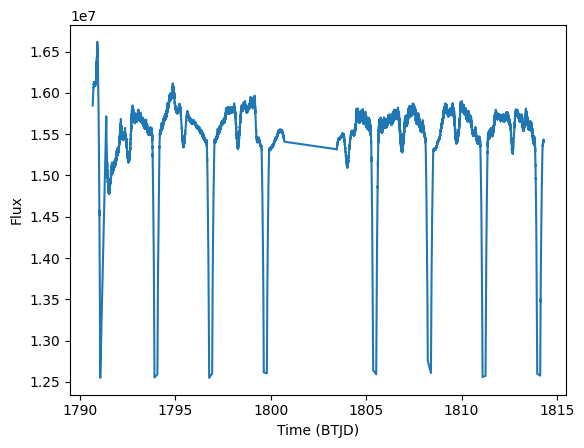

In [ ]:
lc_clean = lc.remove_nans().remove_outliers()       #To remove nan values and outliers from the data
plt.plot(lc_clean.time.value, lc_clean.pdcsap_flux.value)
plt.xlabel("Time (BTJD)")
plt.ylabel("Flux")
plt.show()

The period of Beta Persei is approximately 2.867 days (or 2 days, 20 hours, 49 minutes).

This means that every 2.867 days, it undergoes a brightness dip as its eclipsing binary components pass in front of each other from our line of sight. It is one of the most famous eclipsing binaries, with a well-documented light curve showing periodic dimming due to stellar occultation.

In [ ]:
# Convert to pandas DataFrame
df = lc_clean.to_pandas()
df['time'] = lc_clean.time.value  # .value gets rid of units/astropy Quantity
columns_to_save = ['time', 'sap_flux', 'sap_flux_err', 'pdcsap_flux', 'pdcsap_flux_err']
df1 = df[columns_to_save]

# Create directory if it doesn't exist
output_dir = "data"
os.makedirs(output_dir, exist_ok=True)

# Save to file inside the directory
output_path = os.path.join(output_dir, "lc_sec18.txt")
df1.to_csv(output_path, sep='\t', index=False)

You can save any light curve file to your local machine in this manner.

# 4. Finding periodicity in the light curve

When astronomers collect data over time, like how the brightness of a star changes, they often want to know if there’s a pattern or cycle in the data. For example, does the star become brighter and dimmer in a regular way, like a periodic cycle?<br>


To find these patterns, astronomers use a method called a periodogram, which is a commonly used statistical tool that helps us "listen" for repeating rhythms in the data. One special kind of periodogram is called the Lomb-Scargle (LS) periodogram (after Lomb<a href="#ref1">[1]</a>, and Scargle[\[2\]](#ref2)). This method is very popular in astronomy, especially when the data is not evenly spaced in time.<br>

In an ideal world, astronomers would collect data at regular intervals — for example, every hour, or every night at the same time. But in the real world, especially in astronomy, this is practically impossible.<br>

There are many reasons why data might not be evenly spaced:
- The weather might be bad for telescope operation, for example, clouds, rain, high winds, etc.<br>
- The object might only be visible during certain seasons.<br>
- The telescope might be busy or offline.<br>
- It might be too expensive or difficult to observe constantly.<br>

As a result, the data might be collected at irregular times. This makes it difficult to find patterns using standard tools like the Fourier Transform, which works best with evenly spaced data. <br>

### How Does the LS periodogram Work?
Input: <br>
- A dataset containing:<br>
    - Times when data was collected (not equally spaced). <br>
    - The values recorded at those times (e.g., brightness of a star). <br>

Processing:<br>
- It checks many different frequencies (like testing many possible rhythms) and calculates how well each one fits your data.

Output:<br>
- It gives us another dataset with:<br>
    - Frequency (or period).<br>
    - Power (strength of the signal).<br>


- The taller the peak, the stronger the evidence for a repeating pattern at that frequency.<br>

Below, we use the in-built Python package 'LombScargle' to calculate the periodogram for our data.


In [ ]:
ls = LombScargle(lc_clean.time.value, lc_clean.pdcsap_flux.value, lc_clean.pdcsap_flux_err.value )
freq, power = ls.autopower(nyquist_factor=1)

The Nyquist factor 1 means we would like to explore the periodogram to be calculated up to the Nyquist frequency, which is the maximum frequency you can capture correctly, and it’s exactly half of the sampling rate (cadence between two data points).

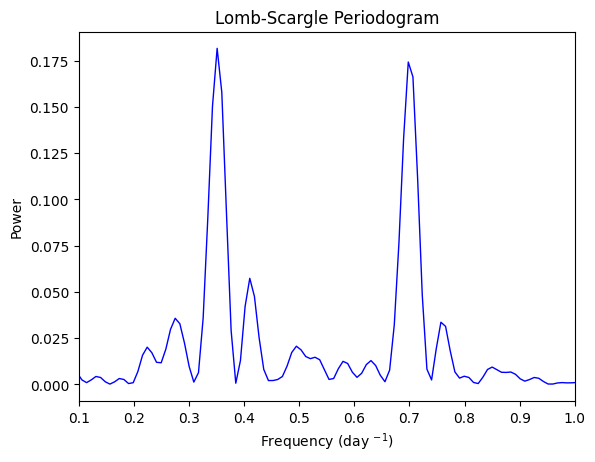

In [ ]:
#period = 1 / freq
plt.plot(freq, power,color='blue',lw=1.0)
plt.xlim(0.1,1)
plt.ylim()
plt.xlabel("Frequency (day $^{-1}$)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")
plt.show()

In [ ]:
best_freq = freq[np.argmax(power)]
best_period = 1/best_freq
print(f"Best frequency: {best_freq:.4f} day⁻¹, Best period: {best_period:.4f} days")

Best frequency: 0.3511 day⁻¹, Best period: 2.8486 days


# 5. References

1.  <a id="ref1"></a>Lomb, N.R. Least-squares frequency analysis of unequally spaced data. Ap&SS 39 pp. 447-462 (1976)
2.  <a id="ref2"></a>Scargle, J. D. Studies in astronomical time series analysis. II - Statistical aspects of spectral analysis of unevenly spaced data. ApJ 1:263 pp. 835-853 (1982)

# 6. Exercise

1. Generate light curves of different sectors. Do you see any difference?
2. Generate periodograms of different light curves. What period did you derive?
3. What frequency is at ~0.70 day$^{-1}$?

## Additional Resources

Getting started with Time series with Astropy: <https://docs.astropy.org/en/stable/timeseries/index.html>

Lomb Scargle periodograms: <https://docs.astropy.org/en/stable/timeseries/lombscargle.html>

Lomb-Scargle Periodograms for Multiband Data: <https://docs.astropy.org/en/stable/timeseries/lombscarglemb.html>

Lightkurve Tutorials: <https://lightkurve.github.io/lightkurve/tutorials/index.html>

TESS and Kepler Data: <https://lightkurve.github.io/lightkurve/tutorials/1-getting-started/searching-for-data-products.html>

Altaipony Flare Lightcurve Tutorial: <https://altaipony.readthedocs.io/en/latest/tutorials/index.html>

Stingray: <https://docs.stingray.science/en/stable/index.html>

High Energy time analysis with Gammapy: <https://docs.gammapy.org/dev/tutorials/analysis-time/light_curve_flare.html>